# Toxic Comments Classification

Miguel A. Cece, Paulo Alves

Neste arquivo estamos montando o vocabulario a partir de todo o dataset

In [1]:
from nltk.tokenize import word_tokenize
import pandas as pd
import math
import seaborn as sns
from collections import Counter
import re
import random
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv('./data/Toxic/train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
def clean_text(text):
    replaced = re.sub('[^a-zA-Z0-9 | \d | _]', ' ', text)
    return replaced.lower()

In [4]:
#USANDO DATAFRAME REDUZIDO
def create_lexicon(dataframe):
    lexicon = []
    for i in range(math.floor(len(dataframe))):
        lexicon += word_tokenize(clean_text(dataframe.get_value(i, 'comment_text')))
    return lexicon

In [5]:
def repeated_words(lex, n_of_occurences, plot=False):
    w_counts = Counter(lex)
    w_counts_list = []
    w_list = []
    for w in w_counts:
        if w_counts[w]>n_of_occurences:
            w_list.append(w)
            w_counts_list.append(w_counts[w])
    zipada = sorted(zip(w_counts_list, w_list))
    w_counts_list, w_list = zip(*zipada)
    if plot:
        fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
        y_pos = np.arange(len(w_list))
        plt.bar(y_pos, w_counts_list, align='center')
        plt.xticks(y_pos, w_list)
        plt.ylabel('Numero de Ocorrencias')
        plt.title('Palavas com mais de '+str(n_of_occurences)+' Ocorrencias')
        plt.show()
    return w_list, w_counts_list

In [6]:
test = df.get_value(random.randint(0, len(df)), 'comment_text')
print("Original", "\n",test,"\n")
test = clean_text(test)
print("Clean Text","\n",test)

Original 
 I've created a special here. 

Clean Text 
 i ve created a special here 


In [7]:
test = create_lexicon(df)

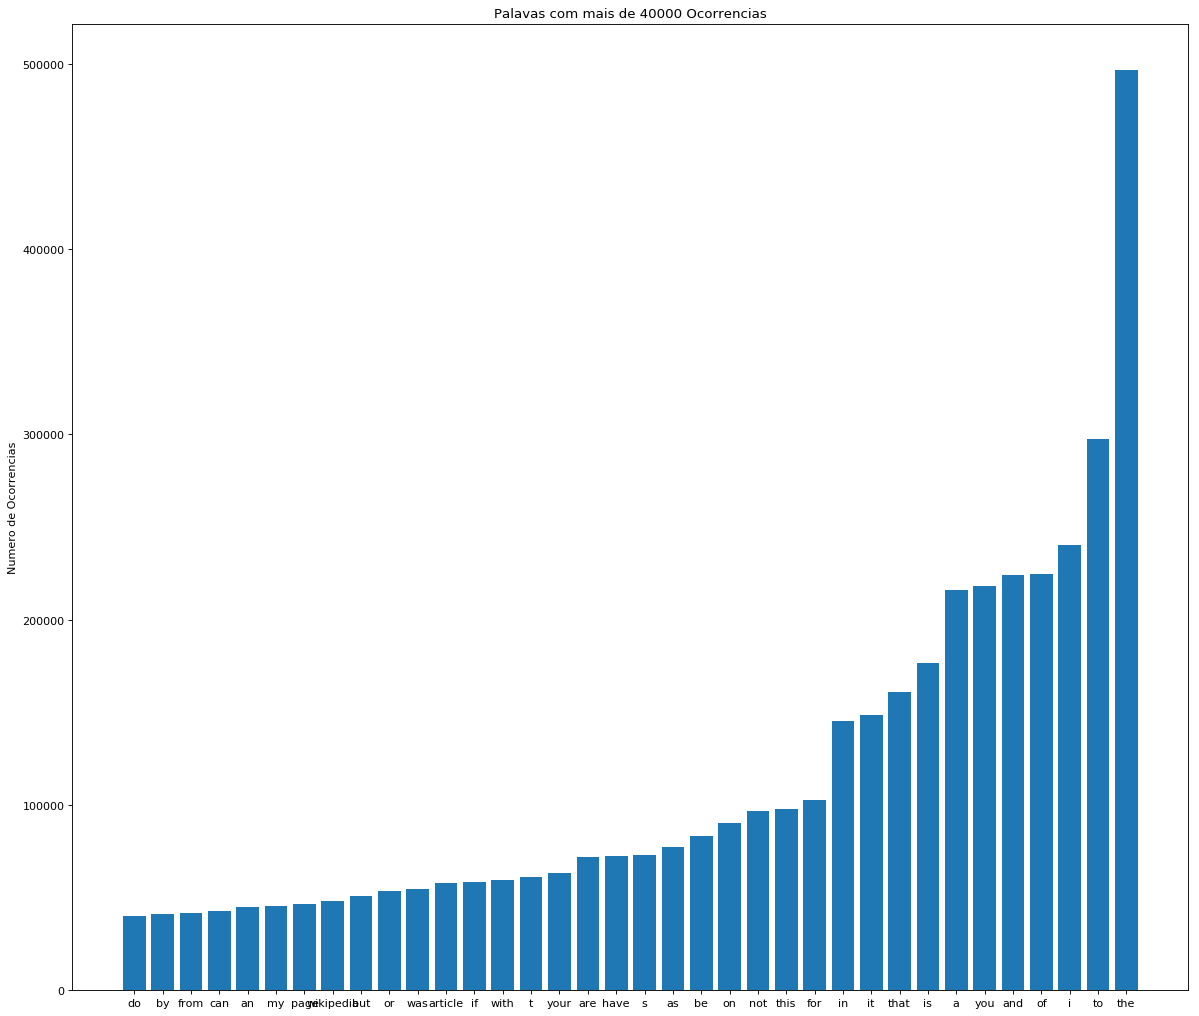

In [8]:
r_words, n_of_occurences = repeated_words(test, 40000, plot=True)

In [9]:
toxic_part = df[df.toxic + df.severe_toxic + df.obscene + df.threat + df.insult + df.identity_hate != 0]
toxic_part.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [10]:
print("{} toxic coments on a {} coments dataset".format(len(toxic_part), len(df)))

16225 toxic coments on a 159571 coments dataset


In [11]:
toxic_lex = create_lexicon(toxic_part.reset_index(drop=True))

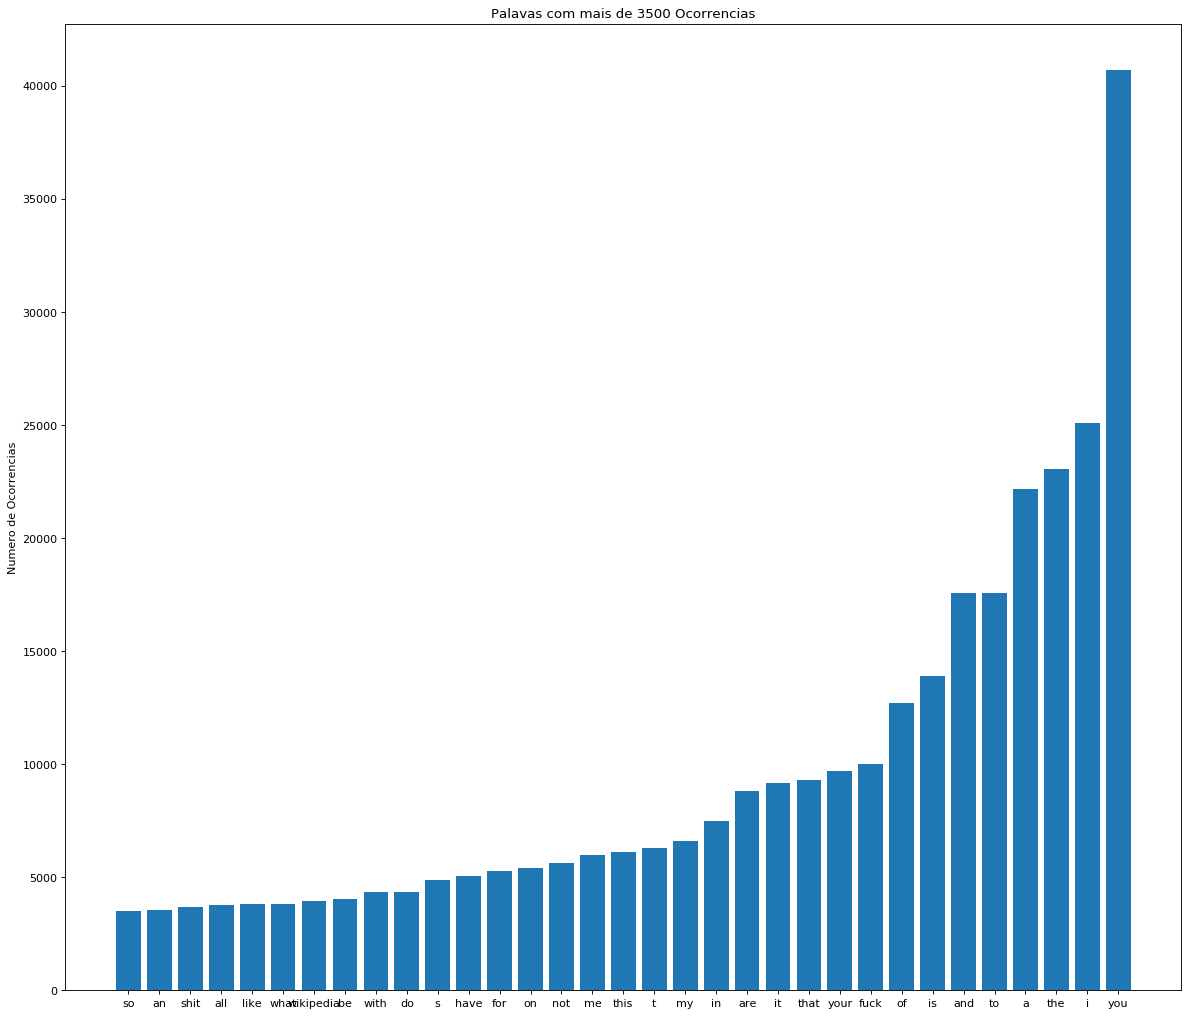

In [12]:
r_toxic_words, n_of_toxic_occurences = repeated_words(toxic_lex, 3500, plot=True)

Construindo o vocabulario

In [13]:
vocabulary = list(set(test))
print("O dataset tem um total de {} palavas, sendo {} palavras unicas".format(len(test), len(vocabulary)))

O dataset tem um total de 11048828 palavas, sendo 188039 palavras unicas


removendo palavras que aparecem menos de 3 vezes

In [14]:
vocabulary, _ = repeated_words(test, 2, plot=False)

In [15]:
print(len(vocabulary))

62304


Stemming

In [16]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()

stmd_vocabulary = []
for w in vocabulary:
    if len(w) < 20:
        stmd_vocabulary.append(ps.stem(w))

In [17]:
print("Usando o stemmer o numero de palavras unicas é reduzido de {} para {}".format(len(vocabulary), len(stmd_vocabulary)))

Usando o stemmer o numero de palavras unicas é reduzido de 62304 para 62181


In [18]:
def text_to_array(text, vocabulary):
    voc_array = np.zeros(len(vocabulary))
    tok_text = word_tokenize(clean_text(text))
    for j in tok_text:
        count = 0
        for i in vocabulary:
            if j == i:
                voc_array[count] += 1
            count += 1
    return voc_array

In [19]:
_ = text_to_array("it is just the test test phrase", vocabulary)
print(_)

[ 0.  0.  0. ...,  0.  0.  1.]


In [20]:
non_toxic_part =df[df.toxic + df.severe_toxic + df.obscene + df.threat + df.insult + df.identity_hate == 0]

def load_batch(toxic, non_toxic, vocabulary, batch_size):
    toxic = toxic.reset_index(drop=True)
    non_toxic = non_toxic.reset_index()
    toxic.head()
    if batch_size % 2 != 0:
        print("use a pair number to batch size")
        return -1
    toxic = [text_to_array(toxic.get_value(random.randint(0,len(toxic)), 'comment_text'), vocabulary) for i in range(0,int(batch_size/2))]
    non_toxic = [text_to_array(non_toxic.get_value(random.randint(0,len(non_toxic)), 'comment_text'), vocabulary) for i in range(0,int(batch_size/2))]
    toxic = list(zip(toxic, [[0,1] for i in range(len(toxic))]))
    non_toxic = list(zip(non_toxic, [[1,0] for i in range(len(non_toxic))]))
    
    batch = toxic + non_toxic
    batch = random.sample(list(batch), batch_size)
    return zip(*batch)

In [21]:
test1, test2 = load_batch(toxic_part, non_toxic_part, vocabulary, 10)

In [22]:
print(test1)
print(test2)

(array([ 0.,  0.,  0., ...,  1.,  1.,  0.]), array([ 0.,  0.,  0., ...,  0.,  3.,  6.]), array([ 0.,  0.,  0., ...,  0.,  1.,  8.]), array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), array([ 0.,  0.,  0., ...,  0.,  1.,  5.]), array([ 0.,  0.,  0., ...,  1.,  0.,  0.]), array([ 0.,  0.,  0., ...,  0.,  0.,  1.]), array([ 0.,  0.,  0., ...,  3.,  4.,  5.]), array([ 0.,  0.,  0., ...,  0.,  2.,  1.]), array([ 0.,  0.,  0., ...,  1.,  0.,  0.]))
([1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1])


# Construindo o Modelo

In [23]:
import tensorflow as tf

In [24]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(init_random_dist)

In [25]:
def init_bias (shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

In [26]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [27]:
n_of_features = len(vocabulary)
batch_size = 30

In [28]:
x = tf.placeholder(tf.float32, [batch_size, n_of_features])
y_ = tf.placeholder(tf.float32, [batch_size, 2])

In [29]:
full_layer_one = tf.nn.relu(normal_full_layer(x, 10))

In [30]:
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one, keep_prob=hold_prob)

In [31]:
y_pred = normal_full_layer(full_one_dropout, 2)

In [32]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_pred))

In [33]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

# Executando o modelo

In [34]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [35]:
steps = 500

In [36]:
plot_data = []

with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        batch_x, batch_y = load_batch(toxic_part, non_toxic_part, vocabulary, batch_size)
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        feed = {x:batch_x, y_:batch_y, hold_prob:0.5}
        sess.run(train, feed_dict = feed)
        
        if i%10 == 0:
            temp_plot = sess.run(cross_entropy, feed_dict = feed)
            
            matches = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_, 1))
            acc = tf.reduce_mean(tf.cast(matches, tf.float32))
#rodando acuracy fora do set de validacao
            batch_x, batch_y = load_batch(toxic_part, non_toxic_part, vocabulary, batch_size)
            accuracy = sess.run(acc, feed_dict={x:batch_x, y_:batch_y, hold_prob:1.0})
#             accuracy = sess.run(acc, feed_dict={x:validation_data, y_:validation_label, hold_prob:1.0})
#             plot_data.append([temp_plot, accuracy])
#             if i%100 == 0:
            print('>  ON STEP: {:8} - COST: {: 16.6f} - ACCURACY: {: >#16.6f}'.format(i, temp_plot, accuracy))
#             print('>  ON STEP: {:8} - COST: {: 16.6f}'.format(i, temp_plot))
            
    #saving trained model
    save_path = saver.save(sess, "./seedlings-model.ckpt")
    print("Model saved in path: %s" % save_path)

>  ON STEP:        0 - COST:         0.696239 - ACCURACY:         0.466667
>  ON STEP:       10 - COST:         0.704795 - ACCURACY:         0.466667
>  ON STEP:       20 - COST:         0.801413 - ACCURACY:         0.533333
>  ON STEP:       30 - COST:         0.694375 - ACCURACY:         0.600000
>  ON STEP:       40 - COST:         0.794730 - ACCURACY:         0.500000
>  ON STEP:       50 - COST:         0.660603 - ACCURACY:         0.500000
>  ON STEP:       60 - COST:         1.723163 - ACCURACY:         0.433333
>  ON STEP:       70 - COST:         0.667655 - ACCURACY:         0.700000
>  ON STEP:       80 - COST:         0.638727 - ACCURACY:         0.633333
>  ON STEP:       90 - COST:         0.652587 - ACCURACY:         0.666667
>  ON STEP:      100 - COST:         0.651344 - ACCURACY:         0.700000
>  ON STEP:      110 - COST:         0.651408 - ACCURACY:         0.633333
>  ON STEP:      120 - COST:         0.615487 - ACCURACY:         0.800000
>  ON STEP:      130 - CO